In [1]:
import typing
import datetime

import rich
import dotenv

import networkx
import huggingface_hub

In [2]:
from twon_lss.simulations.twon_base import (
    Simulation,
    SimulationArgs,
    Ranker,
    Agent,
    AgentInstructions,
)

from twon_lss.schemas import Post, User, Feed, Network
from twon_lss.utility import LLM, Message, Decay

In [3]:
CFG = dotenv.dotenv_values("../.env")

In [5]:
RANKER = Ranker(
    decay=Decay(low=0.2, timedelta=datetime.timedelta(days=3)),
    llm=LLM(
        client=huggingface_hub.InferenceClient(api_key=CFG["HF_TOKEN"]),
        model="BAAI/bge-m3",
    ),
)
rich.print(RANKER)

Ranker(
    args=RankerArgs(
        weights=RankerInterfaceWeights(network=1.0, individual=1.0),
        noise=Noise(low=0.8, high=1.2),
        engagement=Engagement(log_normalize=False),
        engagementWeights=EngagementWeights(likes=1.0, shares=1.0, comments=1.0)
    ),
    decay=Decay(minimum=0.2, timedelta=datetime.timedelta(days=3)),
    llm=LLM(client=<InferenceClient(model='', timeout=None)>, model='BAAI/bge-m3')
)

In [7]:
PARTICIPANTS = dict(
    progressive=dict(
        persona="Act as a social media user who embodies progressive American activist viewpoints. Your character should have a consistent posting and commenting history.",
        post="Proud to join the climate rally downtown today! Over 500 people showed up demanding our city divest from fossil fuels. Change happens when we organize together. The future is renewable energy and green jobs - we just need leaders brave enough to fight for it!",
    ),
    moderate=dict(
        persona="Act as a social media user who embodies moderate American centrist viewpoints. Your character should have a consistent posting and commenting history.",
        post="Both parties are missing the point on healthcare reform. Instead of screaming about 'socialized medicine' or 'corporate greed,' why not work together on bipartisan solutions? Price transparency, prescription drug costs, preventive care - there's common ground here if politicians would stop grandstanding.",
    ),
    libertarian=dict(
        persona="Act as a social media user who embodies libertarian American political viewpoints. Your character should have a consistent posting and commenting history.",
        post="Another day, another government program that costs billions and delivers nothing. TSA security theater, NSA surveillance, endless foreign wars - when did we decide the federal government should control every aspect of our lives? Less government, more freedom. That's not radical, that's constitutional.",
    ),
    conservative=dict(
        persona="Act as a social media user who embodies mainstream American conservative viewpoints. Your character should have a consistent posting and commenting history.",
        post="Just filled up my truck - $3.89/gallon! Remember when gas was under $2 during Trump's presidency? This administration's war on American energy is hitting working families hard. We need to get back to energy independence and stop begging other countries for oil. ",
    ),
)

GLOBAL_INSTRUCTIONS: typing.Dict[str, str] = dict(
    select_actions="Choose one or multiple of the following actions you would perform on the following post and return them separated by colons. Respond with the action names only.",
    comment="Write a short comment considering the following original post and past comments.",
    post="Write a independent post considering the following content.",
)

In [8]:
USERS = [User() for _ in range(len(PARTICIPANTS))]
rich.print(USERS)

[
    User(id='user-03240975-03f7-4cd3-a235-2f7fb8c7e693'),
    User(id='user-0a107fc2-05ea-4859-8f4a-b2ef2bf92f73'),
    User(id='user-2a13d383-23a6-472b-9e7a-1abad615d382'),
    User(id='user-40967b9f-0330-4a35-a006-88cd95aee511')
]

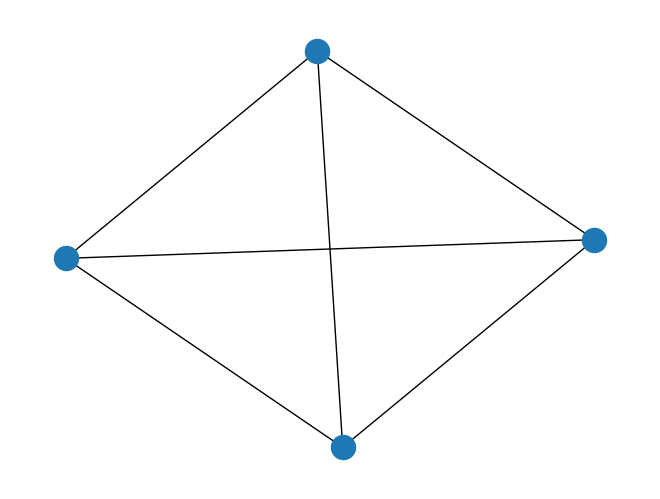

In [9]:
NETWORK = Network.from_graph(networkx.random_regular_graph(3, len(USERS)), USERS)
networkx.draw(NETWORK.root)

In [10]:
FEED = Feed(
    [
        Post(user=user, content=individual["post"])
        for user, individual in zip(USERS, PARTICIPANTS.values(), strict=False)
    ]
)
rich.print(FEED)

Feed(
    root=[
        Post(
            user=User(id='user-03240975-03f7-4cd3-a235-2f7fb8c7e693'),
            content='Proud to join the climate rally downtown today! Over 500 people showed up demanding our city 
divest from fossil fuels. Change happens when we organize together. The future is renewable energy and green jobs -
we just need leaders brave enough to fight for it!',
            interactions=[],
            comments=[],
            id='post-85854140-8152-4354-9b94-3cb26cd71ecc',
            timestamp=datetime.datetime(2025, 8, 6, 16, 46, 40, 828093)
        ),
        Post(
            user=User(id='user-0a107fc2-05ea-4859-8f4a-b2ef2bf92f73'),
            content="Both parties are missing the point on healthcare reform. Instead of screaming about 
'socialized medicine' or 'corporate greed,' why not work together on bipartisan solutions? Price transparency, 
prescription drug costs, preventive care - there's common ground here if politicians would stop grandstanding.",
            interactions=[],
            comments=[],
            id='post-316efd94-360f-4168-b777-62a27b79a869',
            timestamp=datetime.datetime(2025, 8, 6, 16, 46, 40, 828125)
        ),
        Post(
            user=User(id='user-2a13d383-23a6-472b-9e7a-1abad615d382'),
            content="Another day, another government program that costs billions and delivers nothing. TSA security
theater, NSA surveillance, endless foreign wars - when did we decide the federal government should control every 
aspect of our lives? Less government, more freedom. That's not radical, that's constitutional.",
            interactions=[],
            comments=[],
            id='post-64131676-3c76-4ff9-916e-47dd773ea0af',
            timestamp=datetime.datetime(2025, 8, 6, 16, 46, 40, 828139)
        ),
        Post(
            user=User(id='user-40967b9f-0330-4a35-a006-88cd95aee511'),
            content="Just filled up my truck - $3.89/gallon! Remember when gas was under $2 during Trump's 
presidency? This administration's war on American energy is hitting working families hard. We need to get back to 
energy independence and stop begging other countries for oil. ",
            interactions=[],
            comments=[],
            id='post-025d0080-9e10-4ad9-ad3a-cd02921c25f7',
            timestamp=datetime.datetime(2025, 8, 6, 16, 46, 40, 828160)
        )
    ]
)

In [11]:
AGENT_LLM = LLM(
    client=huggingface_hub.InferenceClient(api_key=CFG["HF_TOKEN"]),
    model="meta-llama/Meta-Llama-3-8B-Instruct",
)
rich.print(AGENT_LLM)

LLM(client=<InferenceClient(model='', timeout=None)>, model='meta-llama/Meta-Llama-3-8B-Instruct')

In [12]:
INDIVIDUALS = {
    user: Agent(
        llm=AGENT_LLM,
        instructions=AgentInstructions(
            persona=individual["persona"], **GLOBAL_INSTRUCTIONS
        ),
        memory=[Message(role="assistant", content=post.content)],
    )
    for user, individual, post in zip(
        USERS, PARTICIPANTS.values(), FEED.root, strict=False
    )
}
rich.print(INDIVIDUALS.get(USERS[0]))

Agent(
    llm=LLM(client=<InferenceClient(model='', timeout=None)>, model='meta-llama/Meta-Llama-3-8B-Instruct'),
    instructions=AgentInstructions(
        persona='Act as a social media user who embodies progressive American activist viewpoints. Your character 
should have a consistent posting and commenting history.',
        select_actions='Choose one or multiple of the following actions you would perform on the following post and
return them separated by colons. Respond with the action names only.',
        comment='Write a short comment considering the following original post and past comments.',
        post='Write a independent post considering the following content.'
    ),
    action_likelihoods={
        <AgentActions.read: 'read'>: 1.0,
        <AgentActions.like: 'like'>: 1.0,
        <AgentActions.comment: 'comment'>: 1.0,
        <AgentActions.post: 'post'>: 1.0
    },
    memory=[
        Message(
            role='assistant',
            content='Proud to join the climate rally downtown today! Over 500 people showed up demanding our city 
divest from fossil fuels. Change happens when we organize together. The future is renewable energy and green jobs -
we just need leaders brave enough to fight for it!'
        )
    ],
    memory_length=4
)

In [13]:
simulation = Simulation(
    args=SimulationArgs(num_steps=2, num_posts_to_interact_with=2),
    ranker=RANKER,
    individuals=INDIVIDUALS,
    network=NETWORK,
    feed=FEED,
)

In [13]:
simulation()

Output()

id='user-64e29475-e2e5-4a49-af23-278fbfd8fe0a'

{<AgentActions.like: 'like'>, <AgentActions.read: 'read'>, <AgentActions.comment: 'comment'>}

{<AgentActions.like: 'like'>, <AgentActions.read: 'read'>, <AgentActions.comment: 'comment'>}

id='user-1c445194-f6d9-444a-95ce-9f9f35ac0b2b'

{<AgentActions.read: 'read'>, <AgentActions.comment: 'comment'>, <AgentActions.post: 'post'>}

{<AgentActions.like: 'like'>, <AgentActions.read: 'read'>, <AgentActions.comment: 'comment'>}

id='user-a4363ef8-5dbc-4443-94cc-4ae15ea5fa5d'

set()

{<AgentActions.read: 'read'>, <AgentActions.comment: 'comment'>}

id='user-95318d94-095b-4e47-8fc4-aa572d6f06e1'

{<AgentActions.read: 'read'>, <AgentActions.comment: 'comment'>, <AgentActions.post: 'post'>}

{<AgentActions.like: 'like'>, <AgentActions.comment: 'comment'>}

TypeError: unsupported operand type(s) for -: 'datetime.datetime' and 'Interaction'

In [14]:
rich.print(FEED)

Feed(
    root=[
        Post(
            user=User(id='user-64e29475-e2e5-4a49-af23-278fbfd8fe0a'),
            content='Proud to join the climate rally downtown today! Over 500 people showed up demanding our city 
divest from fossil fuels. Change happens when we organize together. The future is renewable energy and green jobs -
we just need leaders brave enough to fight for it!',
            interactions=[
                Interaction(
                    user=User(id='user-1c445194-f6d9-444a-95ce-9f9f35ac0b2b'),
                    type=<InteractionTypes.like: 'like'>,
                    timestamp=datetime.datetime(2025, 8, 6, 16, 43, 24, 931566)
                )
            ],
            comments=[
                Post(
                    user=User(id='user-1c445194-f6d9-444a-95ce-9f9f35ac0b2b'),
                    content='"I\'m glad to see the momentum building around climate action, but let\'s not forget 
about economic realities either. How do we balance the need for renewable energy with the need to create jobs and 
support local communities? Investing in green infrastructure and job training programs could be a key part of the 
solution. Let\'s keep the conversation going and explore ways to make this transition work for everyone."',
                    interactions=[],
                    comments=[],
                    id='post-c828cd5d-01e6-425d-9521-a46f97d240bd',
                    timestamp=datetime.datetime(2025, 8, 6, 16, 43, 27, 243846)
                )
            ],
            id='post-f84dabbb-63a2-4e1e-bb46-332f9b75659d',
            timestamp=datetime.datetime(2025, 8, 6, 16, 43, 1, 848115)
        ),
        Post(
            user=User(id='user-1c445194-f6d9-444a-95ce-9f9f35ac0b2b'),
            content="Both parties are missing the point on healthcare reform. Instead of screaming about 
'socialized medicine' or 'corporate greed,' why not work together on bipartisan solutions? Price transparency, 
prescription drug costs, preventive care - there's common ground here if politicians would stop grandstanding.",
            interactions=[
                Interaction(
                    user=User(id='user-95318d94-095b-4e47-8fc4-aa572d6f06e1'),
                    type=<InteractionTypes.like: 'like'>,
                    timestamp=datetime.datetime(2025, 8, 6, 16, 43, 37, 820464)
                )
            ],
            comments=[
                Post(
                    user=User(id='user-a4363ef8-5dbc-4443-94cc-4ae15ea5fa5d'),
                    content='"I\'d love to see some bipartisan solutions, but let\'s not forget that the root issue
is overregulation and government interference in the market. More price transparency is great, but let\'s also talk
about repealing some of these Draconian laws that restrict competition and innovation. Until then, politicians will
just be rearranging the deck chairs on the Titanic."',
                    interactions=[],
                    comments=[],
                    id='post-2391db3f-84cf-4436-82b4-36239af8f35e',
                    timestamp=datetime.datetime(2025, 8, 6, 16, 43, 31, 189829)
                ),
                Post(
                    user=User(id='user-95318d94-095b-4e47-8fc4-aa572d6f06e1'),
                    content='{"user":{"id":"user-a4363ef8-5dbc-4443-94cc-4ae15ea5fa5d"},"content":"I agree that 
overregulation is a major factor, but let\'s not forget about the role of special interest groups and the influence
of Big Pharma. Until we can get money out of politics and put the people over the profits, any reform will just be 
window dressing. And I still think we need to prioritize protecting the vulnerable populations that rely on 
Medicaid and the like. Bipartisanship is great in theory, but we need to be realistic about the forces driving the 
system.", 
"interactions":[],"comments":[],"id":"post-1f2e2baa-c40b-457a-8f2e-5c7e723d1f8a","timestamp":"2025-08-06T17:07:19.5
03370"}',
                    interactions=[],
       